## Building Transfomer with PyTorch
https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch

To build the Transformer model, the following steps are necessary:

- Importing the libraries and modules.
- Defining the basic building blocks: Multi-head Attention, Position-Wise Feed-Forward Networks, Positional Encoding.
- Building the Encoder block.
- Building the Decoder block.
- Combining the Encoder and Decoder layers to create the complete Transformer network.

### 1. Importing the necessary libraries and modules

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

### 2. Defining the basic building blocks

| Component             | Description                               | Purpose                                                       |
|-----------------------|-------------------------------------------|---------------------------------------------------------------|
| Multi-Head Attention  | Mechanism to focus on different parts of the input | Captures dependencies across different positions in the sequence |
| Feed-Forward Networks | Position-wise fully connected layers      | Transforms the attention outputs, adding complexity          |
| Positional Encoding   | Adds positional information to embeddings | Provides sequence order context to the model                  |
| Layer Normalization   | Normalizes inputs to each sub-layer       | Stabilizes training, improves convergence                    |
| Residual Connections  | Shortcuts between layers                  | Helps in training deeper networks by minimizing gradient issues |
| Dropout               | Randomly zeroes some network connections  | Prevents overfitting by regularizing the model                |


**Multi-head attention**

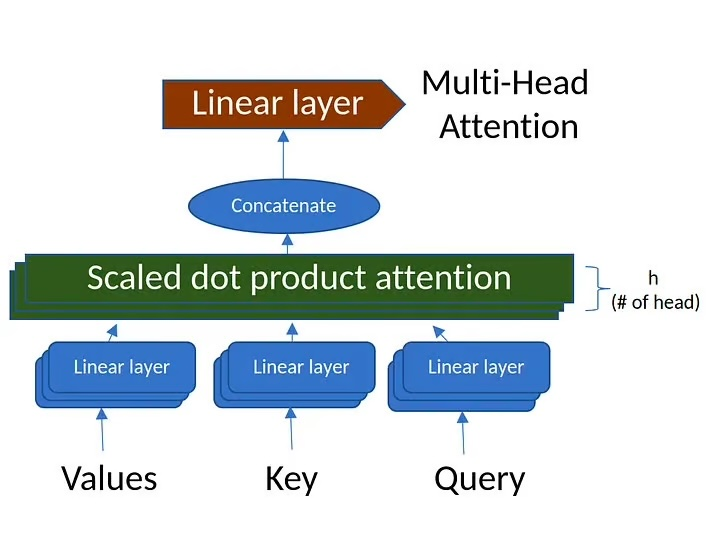

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask==0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

- `d_model` is the dimensionality of each token embedding in the input sequence.

- **Why "d_model must be divisible by num_heads"?**
    - "d_model" must be divisible by "num_heads" because the model splits its total features evenly across all attention heads. If it wasn't divisible, each head would get a fraction of a feature, which doesn't make sense—each head needs a whole number of features to work with. This way, the model can split and later recombine the data cleanly
    - Example
        - Suppose you have `d_model = 8` (so each word is an 8-number vector) and you want to use `num_heads = 2` in your multi-head attention.
        - To split the 8 features evenly between 2 heads, each head will get `8 / 2 = 4` features.
        - So, each head works with a 4-dimensional vector for every word.
        - If you tried `num_heads = 3` with `d_model = 8`, you’d get `8 / 3 = 2.67`, which doesn’t make sense—each head can’t get a fraction of a feature. That’s why `d_model` must be divisible by `num_heads`: so each head gets an equal, whole number of features to process.

---

- **Why use a Mask?**
    - In attention mechanisms, the softmax function is applied to the attention scores to obtain a probability distribution over the input sequence. By setting the attention scores of certain positions to a very large negative value, the softmax output for these positions will be very close to zero. This means these positions will be effectively ignored when computing the weighted sum of the input values.
    - `attn_scores = attn_scores.masked_fill(mask == 0, -1e9):` This line modifies the attention scores based on the mask. Here's what each part does:
        - `mask == 0:` This creates a boolean tensor where each element is `True` if the corresponding element in mask is `0`, and `False` otherwise. In other words, it identifies the positions that should be ignored.
        - `attn_scores.masked_fill(..., -1e9):` This method fills the elements of `attn_scores` at the positions where the mask is `True` (i.e., where `mask == 0`) with a very large negative value (`-1e9`). This effectively makes the attention scores at these positions very small, so they will have negligible influence on the softmax computation that follows.